bool_masked_pos shape: torch.Size([1, 2304])
Number of masked patches: 169
Reconstructed pixel values shape: torch.Size([1, 3, 192, 192])
Loss: 0.2360483556985855
Mean Squared Error (MSE) between original and masked image: 0.0005752776
Mean Squared Error (MSE) between original and reconstructed image: 0.09660483


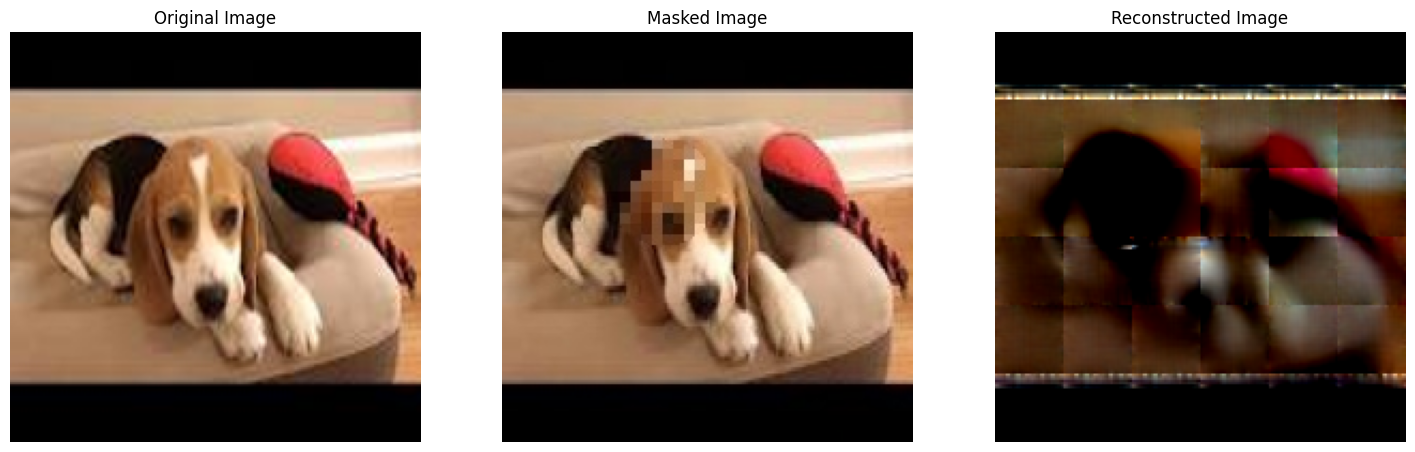

In [31]:
from transformers import AutoImageProcessor, SwinForMaskedImageModeling
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Load and convert original and masked images to RGB
original_image_path = "original_p1.png"
masked_image_path = "masked_p1.png"  # Path to the masked image

original_image = Image.open(original_image_path).convert("RGB")
masked_image = Image.open(masked_image_path).convert("RGB")

# Resize images to the same size used in the masking process
model_image_size = 192  # Ensure this matches the size used in process_dataset
original_image = original_image.resize((model_image_size, model_image_size))
masked_image = masked_image.resize((model_image_size, model_image_size))

# Initialize processor and model
processor_path = "processor"
model_path = "model"

image_processor = AutoImageProcessor.from_pretrained(processor_path)
model = SwinForMaskedImageModeling.from_pretrained(model_path)

# Process original and masked images
pixel_values_original = image_processor(images=original_image, return_tensors="pt").pixel_values
pixel_values_masked = image_processor(images=masked_image, return_tensors="pt").pixel_values

# Calculate the number of patches per row and total patches
patch_size = model.config.patch_size  # Should be 4
num_patches_per_row = model_image_size // patch_size  # 192 // 4 = 48
num_patches = num_patches_per_row ** 2  # 48 * 48 = 2304

# Initialize bool_masked_pos
bool_masked_pos = torch.zeros((1, num_patches), dtype=torch.bool)

# Mosaic parameters (consistent with image masking)
mosaic_start_x = 50
mosaic_start_y = 50
mosaic_width = 50
mosaic_height = 50

# Convert pixel coordinates to patch indices
start_patch_x = mosaic_start_x // patch_size
start_patch_y = mosaic_start_y // patch_size
end_patch_x = (mosaic_start_x + mosaic_width) // patch_size
end_patch_y = (mosaic_start_y + mosaic_height) // patch_size

# Apply mask to the corresponding patches
for i in range(start_patch_y, end_patch_y):
    for j in range(start_patch_x, end_patch_x):
        patch_idx = i * num_patches_per_row + j
        bool_masked_pos[0, patch_idx] = True

print("bool_masked_pos shape:", bool_masked_pos.shape)
print("Number of masked patches:", bool_masked_pos.sum().item())

# Run the model with the masked image
outputs = model(
    pixel_values_masked,
    bool_masked_pos=bool_masked_pos
)

loss, reconstructed_pixel_values = outputs.loss, outputs.reconstruction

# Print results
print("Reconstructed pixel values shape:", reconstructed_pixel_values.shape)
print("Loss:", loss.item())

# Convert reconstructed pixel values to image
reconstructed_image = reconstructed_pixel_values.detach().cpu().squeeze().permute(1, 2, 0).numpy()
reconstructed_image = np.clip(reconstructed_image, 0, 1)  # Ensure values are in [0,1]

# Convert original image to numpy array for comparison
original_image_np = np.array(original_image).astype(np.float32) / 255.0  # Normalize to [0,1]
masked_image_np = np.array(masked_image).astype(np.float32) / 255.0

# Calculate MSE
mse = mean_squared_error(original_image_np.flatten(), reconstructed_image.flatten())

mse_masked = mean_squared_error(original_image_np.flatten(), masked_image_np.flatten())
print("Mean Squared Error (MSE) between original and masked image:", mse_masked)
print("Mean Squared Error (MSE) between original and reconstructed image:", mse)

# Display images
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(original_image_np)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(masked_image_np)
axes[1].set_title("Masked Image")
axes[1].axis("off")

axes[2].imshow(reconstructed_image)
axes[2].set_title("Reconstructed Image")
axes[2].axis("off")

plt.show()
